In [1]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, ttest_ind, mannwhitneyu, wilcoxon
import statsmodels.api as sm
pd.options.display.max_columns = 99
import statsmodels.formula.api as smf
import math 
import scipy.stats as ss
plt.rcParams['font.family'] = 'Myriad Pro'
sns.set_style('white')

clinical_dir  = '/Users/kanaan/SCR/Dataframes_20150820/DF_clinical/'
datadir = '/Users/kanaan/Google Drive/TS-EUROTRAIN/Presentations/2016_06_ESSTS_QSM'

measures = [ #'Age','SNR' , 'CNR' , 'FBER',  'QI1', 
            # 'R_Caud', 'L_Caud', 'R_Puta', 'L_Puta', 'R_Pall', 'L_Pall',
            # 'R_Amyg', 'L_Amyg', 'R_Hipp', 'L_Hipp', 'R_Accu', 'L_Accu',
            # 'R_Thal', 'L_Thal', 'L_Insula', 'R_Insula', 'L_Cingulum', 'R_Cingulum', 
            # 'L_ant_Insula', 'R_ant_Insula', 'L_inf_Insula', 'R_inf_Insula',  'L_sup_Insula', 'R_sup_Insula', 
            # 'L_ant_Cingulum', 'R_ant_Cingulum', 'L_ant_mid_Cingulum', 'R_ant_mid_Cingulum',
            # 'L_post_mid_Cingulum', 'R_post_mid_Cingulum', 'L_post_dors_Cingulum',
            # 'R_post_dors_Cingulum','L_post_vent_Cingulum', 'R_post_vent_Cingulum', 
            # 'L_RN', 'R_RN', 'L_STN', 'R_STN', 'L_SN', 'R_SN',
             'Caud', 'Puta', 'Pall', 'Thal', 'Accu', 'Amyg', 'Hipp', 'RN', 'SN','STN',
             'Insula', #'ant_Insula', 'inf_Insula', 'sup_Insula',
             'Cingulum',# 'post_mid_Cingulum', 'post_dors_Cingulum','post_vent_Cingulum', 'ant_Cingulum', 'ant_mid_Cingulum',
            'BrainStem', 'BasalGanglia',# 'Brain', 'GM', 'WM', 'CSF'
            ]

drop_c =  []
drop_p = ['NL2P', 'STDP', 'HSPP', 'CB4P', 'SA5U']  # Based on quality control of MP2RAGE_UNI 
drop_p = ['HSPP', 'THCP', 'CB4P', 'LA9P', 'RA9P', 'SA5U']
#drop_p = []

In [19]:
def plot(df1,df2,measure):
    palette = sns.xkcd_palette([ "red", 'blue'])
    data = [df1[measure], df2[measure]]
    sns.violinplot(data=data, palette= palette)
    sns.stripplot(data=data,palette= palette, jitter=1)

    
def detect_outliers(df, measure):
    mu = np.mean(df[measure])
    sd = np.std(df[measure])
    thresh = 3
    upper = mu +thresh*sd
    lower = mu -thresh*sd
    outliers = []
    for subject in df.index:
        i = df.loc[subject][measure]
        if i > upper or i < lower:
            outliers.append(subject)
            df.ix[subject, measure] = np.nan
            print outliers
            print 'OUTLIER: %s %s= %s, Limits= (%s,%s)'%(subject, measure, i, lower, upper)
    
    return outliers

def plot_partial_correlation(data, x, y,  regressors = None, color = None, annotate = None, fig_name = None, 
                             dpi = 100, labels = True, jitter = None):
    
    regressors_columns = [data[regressor] for regressor in regressors]
    df_reg = pd.concat(regressors_columns, axis = 1).dropna(axis=0) 
    df = pd.concat([df_reg, data[x], data[y]], axis=1).dropna()
    
    # inititlize grid and plot regression and margins 
    grid = sns.JointGrid(x, y, data=df)#, size=size, ratio=ratio, space=space, #xlim=xlim, ylim=ylim), xlim=xlim, ylim=ylim
    grid.plot_marginals(sns.distplot, color = color, hist=False, kde = True, rug = 0, kde_kws={'shade':True})  
    
    grid.plot_joint(sns.regplot, color = color, x_partial = df[regressors], y_jitter = jitter)
    if labels:
        grid.set_axis_labels(x, y, fontsize= 15, weight='bold', color='blue', labelpad=10)
    else:
        grid.set_axis_labels(None,None)
        
    ## calculate regression parameters 
    
    formula = [ '%s ~ %s'%(y,x) + ' + %s'%regressor for regressor in regressors][0]
    model   = smf.ols(formula=formula, data= df)
    result = model.fit() 
    p_val  = np.round(result.pvalues[1], 3)
    pcor   = math.copysign(np.round(np.sqrt(result.rsquared), 3) , result.params[1])
    
    if annotate:
        plt.annotate('R=%s, P=%s' %(pcor, p_val), xy = annotate, fontsize = 13,  color='r')
                      
    if fig_name:
        plt.savefig(os.path.join(save_fig_dir, fig_name), dpi = dpi, bbox_inches='tight', transparent = True)

df1 = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
df2 = pd.read_csv(os.path.join(datadir, 'patients_a.csv'), index_col = 0)

df1['Brain'] = df1.GM + df1.WM + df1.CSF
df2['Brain'] = df2.GM + df2.WM + df2.CSF

In [20]:
def make_ttest():
    df1 = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
    df2 = pd.read_csv(os.path.join(datadir, 'patients_a.csv'), index_col = 0)

    df1['Brain'] = df1.GM + df1.WM + df1.CSF
    df2['Brain'] = df2.GM + df2.WM + df2.CSF
    df = pd.DataFrame(index= ['Controls', 'Patients', 'Z', 'p_val',], columns=measures)
    for measure in measures:
        #drop_c = detect_outliers(df1, measure)
        #drop_p = detect_outliers(df2, measure)
        t_val, p_val = mannwhitneyu(df1[measure], df2[measure].drop(drop_p, axis = 0))
        #t_val, p_val = ttest_ind(df1[measure], df2[measure].drop(drop_p, axis = 0))
        x = 100
        df.ix['Controls'][measure] = '%s±%s'%(x*np.round(np.mean(df1[measure]),4), 
                                              x*np.round(np.std(df1[measure]),4))     
        df.ix['Patients'][measure] = '%s±%s'%(x*np.round(np.mean(df2[measure].drop(drop_p, axis = 0)),4), 
                                              x*np.round(np.std(df2[measure].drop(drop_p, axis = 0)),4))   
        df.ix['Z'][measure] = np.round(t_val,2)        
        df.ix['p_val'][measure] = np.round(p_val,5)
        
        if p_val < 0.05:
            print measure, 'p =', np.round(p_val,3)
        
    return df.T
x = make_ttest()
x.sort(columns='p_val')

Caud p = 0.045
Puta p = 0.031
Hipp p = 0.026
SN p = 0.024
BrainStem p = 0.028


,Controls,Patients,Z,p_val
SN,11.23±2.43,10.29±4.29,125,0.02436
Hipp,-1.44±0.9,-2.1±1.25,126,0.02596
BrainStem,6.05±2.87,4.35±3.02,127,0.02764
Puta,0.75±1.54,-0.14±1.63,129,0.03128
Caud,1.8±1.23,1.18±0.82,135,0.04465
STN,1.43±3.33,-0.63±2.72,137,0.05001
Accu,-2.2±1.93,-2.98±1.66,139,0.05587
RN,5.5±4.06,3.41±3.71,140,0.059
BasalGanglia,1.98±1.02,1.24±1.2,145,0.07675
Amyg,-3.38±1.25,-4.01±1.46,148,0.0892


In [21]:
pd.DataFrame(x.p_val).sort(columns='p_val')

,p_val
SN,0.02436
Hipp,0.02596
BrainStem,0.02764
Puta,0.03128
Caud,0.04465
STN,0.05001
Accu,0.05587
RN,0.059
BasalGanglia,0.07675
Amyg,0.0892


In [22]:
def make_fdr(df):
    fdr = pd.DataFrame()
    for i in df.index:
        for c in df.columns:
            fdr.ix['%s_%s'%(i,c),'p'] = df.loc[i][c]
    fdr = fdr.dropna()
    fdr = fdr.sort('p')
    
    n_comparisons = len(fdr.index)
    for i, corr in enumerate(fdr.index):
        fdr.ix[corr, 'FDR_threshold'] = np.round((0.05 * (i + 1.) / n_comparisons), 3)
        
    return fdr.reindex()

make_fdr(pd.DataFrame(x.p_val))

,p,FDR_threshold
SN_p_val,0.02436,0.004
Hipp_p_val,0.02596,0.007
BrainStem_p_val,0.02764,0.011
Puta_p_val,0.03128,0.014
Caud_p_val,0.04465,0.018
STN_p_val,0.05001,0.021
Accu_p_val,0.05587,0.025
RN_p_val,0.05900,0.029
BasalGanglia_p_val,0.07675,0.032
Amyg_p_val,0.08920,0.036


In [23]:
controls_a = pd.read_csv(os.path.join(datadir, 'controls_a.csv'), index_col = 0)
patients_a = pd.read_csv(os.path.join(datadir, 'patients_a.csv'), index_col = 0)

In [24]:
def get_clinical(df, pop_name):
    clinical_df = pd.read_csv(os.path.join(clinical_dir, 'clinical_%s.csv'%pop_name), index_col=0)
    
    for subject in df.index:
        if subject in clinical_df.index:
            df.ix[subject, 'YGTSS']             = clinical_df.loc[subject]['YGTSS_Total_Tic_Score']
            df.ix[subject, 'RVTRS']             = clinical_df.loc[subject]['RVTRS']
            df.ix[subject, 'PUTS']              = clinical_df.loc[subject]['puts']
            df.ix[subject, 'YBOCS']             = clinical_df.loc[subject]['YBOCS_Totalscore_Items_1to10']
            df.ix[subject, 'OCI']               = clinical_df.loc[subject]['OCIR_total score']
            df.ix[subject, 'CAARS' ]            = clinical_df.loc[subject]['CAARS_Score_ADHS_Symptoms_Total_Cat_G_T_Score']
            df.ix[subject, 'DSM4']              = clinical_df.loc[subject]['DSM4_clinically_significant_ADHD']
            df.ix[subject, 'QOL']               = clinical_df.loc[subject]['qol_scale']
            df.ix[subject, 'QOLs']              = clinical_df.loc[subject]['qol_score']
            df.ix[subject, 'BDI']               = clinical_df.loc[subject]['BDI12']
            df.ix[subject, 'Ferritin']          = clinical_df.loc[subject]['Ferritin']
    
    return df, clinical_df

In [25]:
Xcontrols_a, controls_a_clinical = get_clinical(controls_a, 'controls_a')
Xpatients_a, patients_a_clinical = get_clinical(patients_a, 'patients_a')

In [26]:
Xpatients_a

,Age,Gender,SNR,CNR,FBER,QI1,R_Caud,L_Caud,R_Puta,L_Puta,R_Pall,L_Pall,R_Amyg,L_Amyg,R_Hipp,L_Hipp,R_Accu,L_Accu,R_Thal,L_Thal,L_ant_Insula,R_ant_Insula,L_inf_Insula,R_inf_Insula,L_sup_Insula,R_sup_Insula,L_Insula,R_Insula,L_ant_Cingulum,R_ant_Cingulum,L_ant_mid_Cingulum,R_ant_mid_Cingulum,L_post_mid_Cingulum,R_post_mid_Cingulum,L_post_dors_Cingulum,R_post_dors_Cingulum,L_post_vent_Cingulum,R_post_vent_Cingulum,L_Cingulum,R_Cingulum,L_RN,R_RN,L_STN,R_STN,L_SN,R_SN,Caud,Puta,Pall,Amyg,Hipp,Accu,Thal,ant_Insula,sup_Insula,inf_Insula,Insula,ant_Cingulum,ant_mid_Cingulum,ant_mid_Cingulum.1,post_mid_Cingulum,post_dors_Cingulum,post_vent_Cingulum,Cingulum,RN,STN,SN,GM,WM,CSF,BasalGanglia,BrainStem,YGTSS,RVTRS,PUTS,YBOCS,OCI,CAARS,DSM4,QOL,QOLs,BDI,Ferritin
BE9P,18,1,2.835440,1.981920,-1.717956,0.222792,0.004667,0.015995,-0.019743,-0.021672,0.083766,0.088876,-0.016206,-0.026334,-0.006319,0.002577,-0.042369,-0.027947,-0.028728,-0.033831,-0.012215,-0.004646,-0.022956,-0.014472,-0.016860,-0.030647,-0.018408,-0.018251,-0.018205,-0.017674,-0.028414,-0.029606,-0.021625,-0.022401,-0.017492,-0.013461,-0.009098,-0.022190,-0.020763,-0.020986,0.021149,0.024191,-0.000818,-0.010868,0.082325,0.074497,0.010331,-0.020708,0.086321,-0.021270,-0.001871,-0.035158,-0.031280,-0.008431,-0.023754,-0.018714,-0.018329,-0.017940,-0.029010,-0.029010,-0.022013,-0.015476,-0.015644,-0.020875,0.022670,-0.005843,0.078411,-0.019257,-0.024675,-0.014283,0.010197,0.031746,3,6,10,0,10,51,no,60,5,8,86.07
HJEP,21,1,2.707997,1.791155,-2.026235,0.255465,0.019591,0.019977,0.007345,0.007670,0.077096,0.063141,-0.032866,-0.022890,-0.026541,-0.019442,-0.016773,-0.021338,-0.024822,-0.024817,-0.027387,-0.021713,-0.029655,-0.020491,-0.028305,-0.031996,-0.028605,-0.025828,-0.019408,-0.012125,-0.030694,-0.029325,-0.015175,-0.014367,-0.011969,-0.006123,-0.029022,-0.020713,-0.020079,-0.016047,0.002212,0.002806,0.015682,-0.012624,0.066200,0.057750,0.019784,0.007508,0.070119,-0.027878,-0.022991,-0.019055,-0.024819,-0.024550,-0.030151,-0.025073,-0.027217,-0.015766,-0.030010,-0.030010,-0.014771,-0.009046,-0.024868,-0.018063,0.002509,0.001529,0.061975,-0.016994,-0.022415,-0.014184,0.019589,0.022004,14,12,26,6,13,57,no,40,23,20,76.43
LA9P,22,1,2.494293,1.590777,-1.288590,0.316772,0.015783,0.022726,0.002522,-0.011651,0.052353,0.061108,-0.026692,-0.029027,0.001953,-0.001989,-0.002122,-0.009788,-0.007434,-0.015051,0.011453,-0.006658,-0.013880,-0.021863,-0.009495,0.003880,-0.007656,-0.007465,-0.011644,-0.019576,-0.026615,-0.008289,-0.019229,-0.007839,0.003625,0.006551,-0.012001,-0.011555,-0.013826,-0.011513,0.021985,0.031026,-0.059762,0.002356,0.038103,0.067144,0.019254,-0.004564,0.056730,-0.027860,-0.000018,-0.005955,-0.011242,0.002398,-0.002808,-0.017872,-0.007561,-0.015610,-0.017452,-0.017452,-0.013534,0.005088,-0.011778,-0.012669,0.026506,-0.028703,0.052624,-0.010444,-0.016182,-0.011670,0.016366,0.016809,15,11,22,19,24,57,no,75,32,17,126.10
RMJP,22,0,2.872812,1.793160,-0.271151,0.210054,0.019364,0.029370,-0.018238,-0.010534,0.057531,0.063983,-0.030252,-0.043734,-0.025417,-0.023276,-0.062597,-0.025768,-0.040442,-0.039599,0.003303,-0.012910,-0.034855,-0.028993,-0.042990,-0.040237,-0.035026,-0.029612,-0.033359,-0.033044,-0.036086,-0.035953,-0.030929,-0.023046,-0.030202,-0.022381,-0.043009,-0.053342,-0.033668,-0.031718,-0.001162,0.007176,0.005730,0.003482,0.075664,0.081779,0.024367,-0.014386,0.060757,-0.036993,-0.024347,-0.044182,-0.040021,-0.004803,-0.041613,-0.031924,-0.032319,-0.033202,-0.036019,-0.036019,-0.026988,-0.026292,-0.048175,-0.032693,0.003007,0.004606,0.078721,-0.027823,-0.033376,-0.021382,0.006639,0.028778,39,13,14,0,0,40,no,60,34,14,NaN
CM5P,27,1,2.832985,1.542618,0.739564,0.250155,0.017701,0.006963,-0.007638,-0.016473,0.049785,0.031573,-0.038841,-0.033303,-0.024286,-0.022038,-0.055975,-0.045606,-0.046230,-0.035966,-0.022287,-0.022913,-0.034372,-0.036034,-0.032835,-0.042759,-0.031729,-0.035857,-0.031511,-0.034055,-0.050279,-0.050545,-0.041928,-0.034715,-0.028507,-0.019124,-0.04893

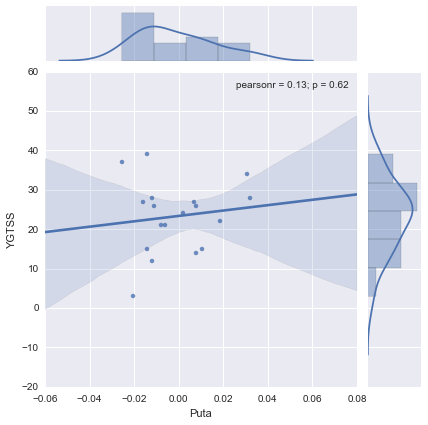

In [27]:
#drop = ['CB4P', 'NL2P', 'YU1P', 'LA9P','SA5U']
drop = drop_p # +  ['SA5U'] 
measure_1 = 'Puta'
measure_2 = 'YGTSS'
sns.jointplot(Xpatients_a[measure_1].drop(drop, axis = 0), Xpatients_a[measure_2].drop(drop, axis = 0), kind = 'reg')
#sns.jointplot(Xcontrols_a.Ferritin, Xcontrols_a.R_STN, kind = 'reg')

#plt.savefig('/Users/kanaan/Desktop/YGTSS_R_Ins.png')

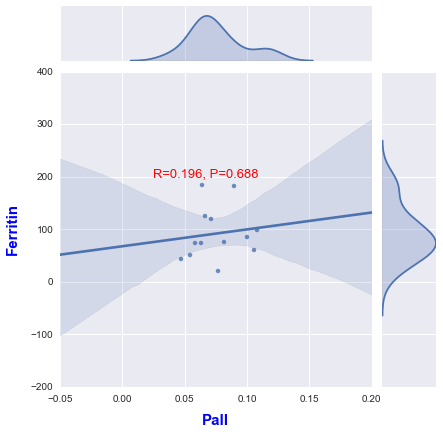

In [28]:
plot_partial_correlation(Xpatients_a.drop(drop, axis = 0), 'Pall', 'Ferritin',  regressors =['Age', 'Gender'] , 
                         color = None, annotate = (0.025, 200), fig_name = None, 
                         dpi = 100, labels = True, jitter = None)

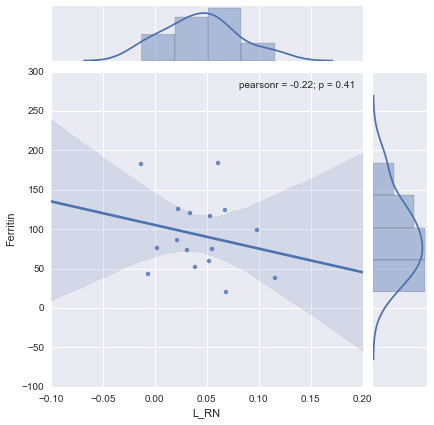

In [29]:
drop = ['SA5U']
sns.jointplot(data = Xpatients_a.drop(drop, axis =0), x = 'L_RN', y = 'Ferritin', kind = 'reg')

In [30]:
Xpatients_a.Ferritin

BE9P     86.07
HJEP     76.43
LA9P    126.10
RMJP       NaN
CM5P     42.69
LT5P    120.10
CF1P     20.51
SM6U    124.60
EB2P     73.03
HHQP    182.40
SGKP       NaN
SA5U    562.80
THCP    117.10
STDP     98.63
NT6P     51.63
SBQP       NaN
TT3P       NaN
CB4P       NaN
YU1P       NaN
RA9P       NaN
SULP    183.80
HSPP     37.98
KDDP     74.30
NL2P     59.90
Name: Ferritin, dtype: float64

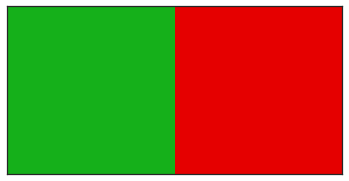

In [31]:
%matplotlib inline
import os 
import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

plt.rcParams['font.family'] = 'Myriad Pro'
p = sns.palplot(sns.xkcd_palette(['green', "red"]), size = 3)

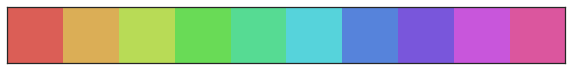

In [ ]:
sns.palplot(sns.color_palette("hls",10 ))

In [ ]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'SN' 
measure_2 = 'STN'
measure_3 = 'RN'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(0, 23)
#ax2.set_ylim(-10, 18) 
#ax3.set_ylim(-10, 30)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_1.png'), dpi = 600, bbox_inches='tight', transparent = False)

In [ ]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'BrainStem' 
measure_2 = 'Caud'
measure_3 = 'Puta'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[3:6]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(-5, 22)
#ax2.set_ylim(-5, 10)
#ax3.set_ylim(-5, 8)


ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_2.png'), dpi = 600, bbox_inches='tight', transparent = False)

In [ ]:
sns.set_style('darkgrid', {"xtick.direction": "in","ytick.direction": "in"})
f, (ax1,ax2,ax3)= plt.subplots(nrows = 1, ncols = 3)
f.set_size_inches([20,10])

jitter = 0.05
drop_p = drop_p + ['RA9P']
fontsize = 22

C = controls_a.drop(drop_c, axis = 0) * 100
P = patients_a.drop(drop_p, axis = 0) * 100

measure_1 = 'Pall' 
measure_2 = 'Thal'
measure_3 = 'BasalGanglia'

data_1 = [C[measure_1],     P[measure_1]]
data_2 = [C[measure_2],     P[measure_2]]
data_3 = [C[measure_3],     P[measure_3]]

palette = ['#3498db', '#2ecc71', '#e74c3c']
#palette = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
palette = sns.color_palette("hls", 10)[6:9]

sns.violinplot(data = data_1, color = palette[0], ax = ax1)
sns.stripplot(data=data_1, color = palette[0], jitter= jitter, ax = ax1)
sns.pointplot(data=data_1, color = palette[0], linestyles=['--'], markers=['o'], ax =ax1)
ax1.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_2, color = palette[1],ax = ax2)
sns.stripplot(data=data_2, color = palette[1], jitter= jitter, ax = ax2)
sns.pointplot(data=data_2, color = palette[1], linestyles=['--'], markers=['o'], ax =ax2)
ax2.tick_params(axis='y', labelsize=fontsize)

sns.violinplot(data = data_3, color = palette[2], ax = ax3)
sns.stripplot(data=data_3, color = palette[2], jitter= jitter, ax = ax3)
sns.pointplot(data=data_3, color = palette[2], linestyles=['--'], markers=['o'], ax =ax3)
ax3.tick_params(axis='y', labelsize=fontsize)

#ax1.set_ylim(1, 16)
#ax2.set_ylim(-9, 9)
#ax3.set_ylim(-2, 8)

ax1.set_xticks([])
ax2.set_xticks([])
ax3.set_xticks([])

f.savefig(os.path.join(datadir,'qsm_py_stats','QSM_STATS_3.png'), dpi = 600, bbox_inches='tight', transparent = False)